# 5.3

prompt:

Cifar 圖片分類 vgg16, vgg19  pretrained (pytorch lightning) to execute on colab並畫出accuracy與loss各一張圖

安装pytorch-lightning

In [5]:
!pip install pytorch-lightning

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | VGG  | 134 M  | train
---------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
537.206   Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=6` reached.


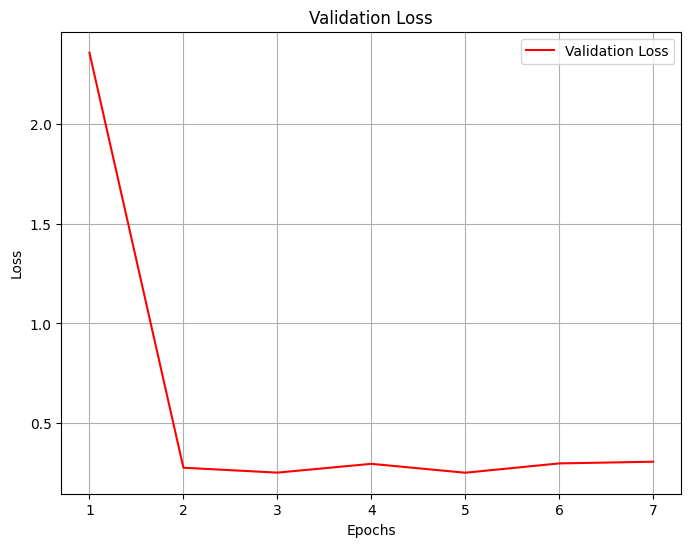

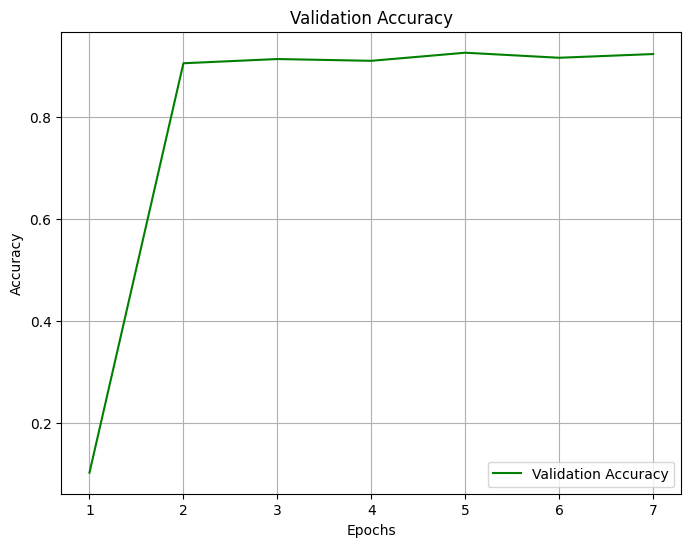

In [6]:
import torch
import torchvision
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import vgg16, vgg19
from pytorch_lightning import LightningModule, Trainer
import matplotlib.pyplot as plt

# 定義數據轉換
transform = transforms.Compose([
    transforms.Resize(224),  # VGG 模型期望 224x224 圖像
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 預訓練均值與標準差
])

# 加載 CIFAR-10 數據集
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 創建數據加載器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 定義模型類
class VGGModel(LightningModule):
    def __init__(self, model_type='vgg16'):
        super(VGGModel, self).__init__()
        # 加載模型
        if model_type == 'vgg16':
            self.model = vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
        elif model_type == 'vgg19':
            self.model = vgg19(weights=torchvision.models.VGG19_Weights.DEFAULT)

        # 修改分類頭
        self.model.classifier[6] = torch.nn.Linear(4096, 10)

        # 儲存每個 epoch 的歷史數據
        self.val_loss_history = []
        self.val_acc_history = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()

        # 返回損失和準確率
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        return {'val_loss': loss, 'val_acc': acc}

    def on_validation_epoch_end(self, outputs=None):
        # 取得最後一個 epoch 的平均損失和準確率
        avg_loss = self.trainer.callback_metrics['val_loss'].item()
        avg_acc = self.trainer.callback_metrics['val_acc'].item()

        # 儲存到歷史記錄中
        self.val_loss_history.append(avg_loss)
        self.val_acc_history.append(avg_acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.0001)

# 繪圖函式
def plot_metrics(model):
    epochs = range(1, len(model.val_loss_history) + 1)

    # 繪製驗證損失
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, model.val_loss_history, 'r-', label='Validation Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # 繪製驗證準確率
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, model.val_acc_history, 'g-', label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

# 選擇模型類型
model = VGGModel(model_type='vgg16')

# 設定 Trainer
trainer = Trainer(max_epochs=6, devices=1 if torch.cuda.is_available() else 1, accelerator="gpu" if torch.cuda.is_available() else "cpu")

# 訓練模型
trainer.fit(model, train_loader, test_loader)

# 呼叫繪圖函式
plot_metrics(model)
